<a href="https://colab.research.google.com/github/Akshatpattiwar512/Generative-Adversarial-Network/blob/main/Auxiliary_Generative_Adversarial_Network_using_Keras_and_Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing Libraries

In [ ]:
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D
from keras.models import Sequential, Model
from keras.layers.advanced_activations import LeakyReLU
  
from tensorflow.keras.optimizers import Adam
  
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Defining the Input shape 
image_shape = (28, 28, 1)
classes = 10
latent_dim = 100
  
# Defining the optimizer and the losses  
optimizer = Adam(0.0002, 0.5)
losses = ['binary_crossentropy','sparse_categorical_crossentropy']

In [ ]:
def build_generator():
  
    model = Sequential()
      
    # Building the input layer 
    model.add(Dense(128 * 7 * 7, activation="relu", input_dim=latent_dim))
    model.add(Reshape((7, 7, 128)))
    model.add(BatchNormalization(momentum=0.82))
    model.add(UpSampling2D())
  
    model.add(Conv2D(128, (3,3), padding="same"))
    model.add(BatchNormalization(momentum=0.82))
    model.add(Activation("relu"))
    model.add(UpSampling2D())
  
    model.add(Conv2D(64, (3,3), padding="same"))
    model.add(BatchNormalization(momentum=0.82))
    model.add(Activation("relu"))
      
    model.add(Conv2D(1, (3,3), padding='same'))
    model.add(Activation("tanh"))
  
    # Generating the output image
    noise = Input(shape=(latent_dim,))
    label = Input(shape=(1,), dtype='int32')
    z = Flatten()(Embedding(classes, latent_dim)(label))
  
    model_input = multiply([noise, z])
    image = model(model_input)
  
    return Model([noise, label], image)

In [ ]:
def build_discriminator():
  
    model = Sequential()
      
    # Building the input layer 
    model.add(Conv2D(16, (3,3), strides=2, input_shape=image_shape, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
  
    model.add(Conv2D(32, (3,3), strides=2, padding="same"))
    model.add(ZeroPadding2D(padding=((0,1),(0,1))))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
  
    model.add(BatchNormalization(momentum=0.8))
  
    model.add(Conv2D(64, (3,3), strides=2, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
  
    model.add(BatchNormalization(momentum=0.8))
  
    model.add(Conv2D(128, (3,3), strides=1, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
  
    model.add(Flatten())
  
    image = Input(shape=image_shape)
  
    # Extract features from images
    features = model(image)
  
    # Building the output layer 
    validity = Dense(1, activation="sigmoid")(features)
    label = Dense(classes, activation="softmax")(features)
  
    return Model(image, [validity, label])

In [ ]:
def display_images(): 
    r = 10
    c = 10
    noise = np.random.normal(0, 1, (r * c,latent_dim)) 
  
    new_labels = np.array([num for _ in range(r) for num in range(c)])
    gen_images = generator.predict([noise, new_labels])
  
    # Rescale images 0 - 1
    gen_images = 0.5 * gen_images + 0.5
  
    fig, axs = plt.subplots(r, c) 
    count = 0
    for i in range(r): 
        for j in range(c): 
            axs[i,j].imshow(gen_images[count,:,:,0], cmap='gray') 
            axs[i,j].axis('off') 
            count += 1
    plt.show() 
    plt.close()

In [ ]:
def train_acgan(epochs, batch_size=128, sample_interval=50):
  
    # Load the dataset
    (X, y), (_, _) = mnist.load_data()
  
    # Configure inputs
    X = X.astype(np.float32)
    X = (X - 127.5) / 127.5
    X = np.expand_dims(X, axis=3)
    y = y.reshape(-1, 1)
  
    # Adversarial ground truths
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))
  
    for epoch in range(epochs):
  
        # Select a random batch of images
        index = np.random.randint(0, X.shape[0], batch_size)
        images = X[index]
  
        # Sample noise as generator input
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
  
        # The labels of the digits that the generator tries to create an
        # image representation of
        new_labels = np.random.randint(0, 10, (batch_size, 1))
  
        # Generate a half batch of new images
        gen_images = generator.predict([noise, new_labels])
  
        image_labels = y[index]
  
        # Training the discriminator
        disc_loss_real = discriminator.train_on_batch(
          images, [valid, image_labels])
        disc_loss_fake = discriminator.train_on_batch(
          gen_images, [fake, new_labels])
        disc_loss = 0.5 * np.add(disc_loss_real, disc_loss_fake)
  
        # Training the generator
        gen_loss = combined.train_on_batch(
          [noise, new_labels], [valid, new_labels])
  
        # Print the accuracies 
        print ("%d [acc.: %.2f%%, op_acc: %.2f%%]" % (
          epoch, 100 * disc_loss[3], 100 * disc_loss[4]))
  
        # display at every defined epoch interval
        if epoch % sample_interval == 0:
            display_images()

11501568/11490434 [==============================] - 0s 0us/step
0 [acc.: 40.62%, op_acc: 7.81%]


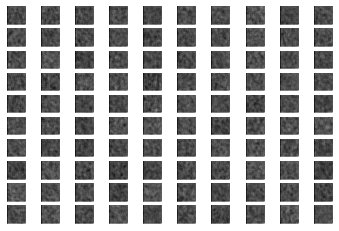

1 [acc.: 48.44%, op_acc: 9.38%]
2 [acc.: 50.00%, op_acc: 9.38%]
3 [acc.: 75.00%, op_acc: 9.38%]
4 [acc.: 75.00%, op_acc: 15.62%]
5 [acc.: 89.06%, op_acc: 6.25%]
6 [acc.: 78.12%, op_acc: 9.38%]
7 [acc.: 68.75%, op_acc: 18.75%]
8 [acc.: 78.12%, op_acc: 9.38%]
9 [acc.: 75.00%, op_acc: 7.81%]
10 [acc.: 75.00%, op_acc: 10.94%]
11 [acc.: 78.12%, op_acc: 10.94%]
12 [acc.: 81.25%, op_acc: 17.19%]
13 [acc.: 84.38%, op_acc: 7.81%]
14 [acc.: 76.56%, op_acc: 17.19%]
15 [acc.: 87.50%, op_acc: 10.94%]
16 [acc.: 87.50%, op_acc: 15.62%]
17 [acc.: 82.81%, op_acc: 4.69%]
18 [acc.: 93.75%, op_acc: 10.94%]
19 [acc.: 85.94%, op_acc: 20.31%]
20 [acc.: 95.31%, op_acc: 17.19%]
21 [acc.: 84.38%, op_acc: 18.75%]
22 [acc.: 84.38%, op_acc: 17.19%]
23 [acc.: 79.69%, op_acc: 21.88%]
24 [acc.: 65.62%, op_acc: 21.88%]
25 [acc.: 76.56%, op_acc: 18.75%]
26 [acc.: 82.81%, op_acc: 18.75%]
27 [acc.: 62.50%, op_acc: 15.62%]
28 [acc.: 50.00%, op_acc: 15.62%]
29 [acc.: 37.50%, op_acc: 28.12%]
30 [acc.: 50.00%, op_acc: 20.31%

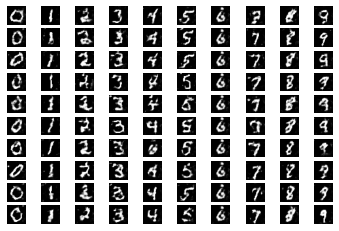

2001 [acc.: 48.44%, op_acc: 90.62%]
2002 [acc.: 54.69%, op_acc: 96.88%]
2003 [acc.: 78.12%, op_acc: 93.75%]
2004 [acc.: 65.62%, op_acc: 93.75%]
2005 [acc.: 51.56%, op_acc: 87.50%]
2006 [acc.: 59.38%, op_acc: 93.75%]
2007 [acc.: 60.94%, op_acc: 96.88%]
2008 [acc.: 71.88%, op_acc: 92.19%]
2009 [acc.: 76.56%, op_acc: 96.88%]
2010 [acc.: 78.12%, op_acc: 93.75%]
2011 [acc.: 42.19%, op_acc: 93.75%]
2012 [acc.: 53.12%, op_acc: 98.44%]
2013 [acc.: 79.69%, op_acc: 90.62%]
2014 [acc.: 65.62%, op_acc: 92.19%]
2015 [acc.: 57.81%, op_acc: 98.44%]
2016 [acc.: 75.00%, op_acc: 92.19%]
2017 [acc.: 35.94%, op_acc: 96.88%]
2018 [acc.: 59.38%, op_acc: 96.88%]
2019 [acc.: 70.31%, op_acc: 89.06%]
2020 [acc.: 51.56%, op_acc: 95.31%]
2021 [acc.: 60.94%, op_acc: 96.88%]
2022 [acc.: 64.06%, op_acc: 93.75%]
2023 [acc.: 57.81%, op_acc: 95.31%]
2024 [acc.: 26.56%, op_acc: 95.31%]
2025 [acc.: 32.81%, op_acc: 92.19%]
2026 [acc.: 46.88%, op_acc: 100.00%]
2027 [acc.: 51.56%, op_acc: 96.88%]
2028 [acc.: 65.62%, op_acc:

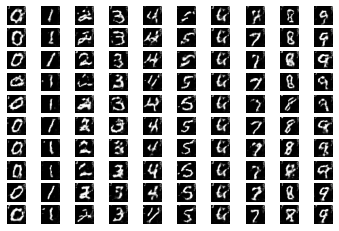

4001 [acc.: 96.88%, op_acc: 92.19%]
4002 [acc.: 79.69%, op_acc: 98.44%]
4003 [acc.: 100.00%, op_acc: 90.62%]
4004 [acc.: 65.62%, op_acc: 95.31%]
4005 [acc.: 87.50%, op_acc: 96.88%]
4006 [acc.: 98.44%, op_acc: 95.31%]
4007 [acc.: 96.88%, op_acc: 95.31%]
4008 [acc.: 98.44%, op_acc: 95.31%]
4009 [acc.: 34.38%, op_acc: 93.75%]
4010 [acc.: 100.00%, op_acc: 92.19%]
4011 [acc.: 85.94%, op_acc: 96.88%]
4012 [acc.: 90.62%, op_acc: 96.88%]
4013 [acc.: 85.94%, op_acc: 90.62%]
4014 [acc.: 100.00%, op_acc: 93.75%]
4015 [acc.: 57.81%, op_acc: 92.19%]
4016 [acc.: 89.06%, op_acc: 95.31%]
4017 [acc.: 87.50%, op_acc: 95.31%]
4018 [acc.: 90.62%, op_acc: 92.19%]
4019 [acc.: 59.38%, op_acc: 98.44%]
4020 [acc.: 100.00%, op_acc: 96.88%]
4021 [acc.: 54.69%, op_acc: 96.88%]
4022 [acc.: 100.00%, op_acc: 96.88%]
4023 [acc.: 81.25%, op_acc: 93.75%]
4024 [acc.: 96.88%, op_acc: 95.31%]
4025 [acc.: 93.75%, op_acc: 93.75%]
4026 [acc.: 79.69%, op_acc: 100.00%]
4027 [acc.: 100.00%, op_acc: 96.88%]
4028 [acc.: 60.94%, o

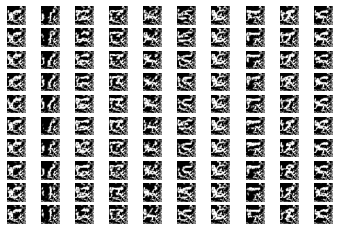

6001 [acc.: 100.00%, op_acc: 100.00%]
6002 [acc.: 100.00%, op_acc: 96.88%]
6003 [acc.: 100.00%, op_acc: 96.88%]
6004 [acc.: 100.00%, op_acc: 98.44%]
6005 [acc.: 100.00%, op_acc: 96.88%]
6006 [acc.: 100.00%, op_acc: 96.88%]
6007 [acc.: 100.00%, op_acc: 92.19%]
6008 [acc.: 100.00%, op_acc: 100.00%]
6009 [acc.: 100.00%, op_acc: 96.88%]
6010 [acc.: 100.00%, op_acc: 98.44%]
6011 [acc.: 100.00%, op_acc: 100.00%]
6012 [acc.: 100.00%, op_acc: 98.44%]
6013 [acc.: 100.00%, op_acc: 95.31%]
6014 [acc.: 100.00%, op_acc: 93.75%]
6015 [acc.: 100.00%, op_acc: 98.44%]
6016 [acc.: 100.00%, op_acc: 96.88%]
6017 [acc.: 100.00%, op_acc: 98.44%]
6018 [acc.: 100.00%, op_acc: 95.31%]
6019 [acc.: 100.00%, op_acc: 92.19%]
6020 [acc.: 100.00%, op_acc: 96.88%]
6021 [acc.: 100.00%, op_acc: 100.00%]
6022 [acc.: 100.00%, op_acc: 100.00%]
6023 [acc.: 100.00%, op_acc: 100.00%]
6024 [acc.: 100.00%, op_acc: 92.19%]
6025 [acc.: 100.00%, op_acc: 100.00%]
6026 [acc.: 100.00%, op_acc: 95.31%]
6027 [acc.: 100.00%, op_acc: 96

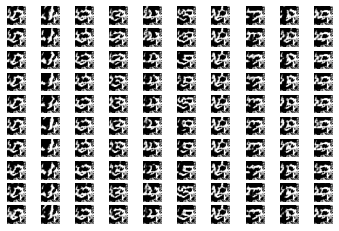

8001 [acc.: 100.00%, op_acc: 98.44%]
8002 [acc.: 100.00%, op_acc: 100.00%]
8003 [acc.: 100.00%, op_acc: 100.00%]
8004 [acc.: 100.00%, op_acc: 98.44%]
8005 [acc.: 100.00%, op_acc: 98.44%]
8006 [acc.: 100.00%, op_acc: 95.31%]
8007 [acc.: 100.00%, op_acc: 96.88%]
8008 [acc.: 100.00%, op_acc: 98.44%]
8009 [acc.: 100.00%, op_acc: 96.88%]
8010 [acc.: 100.00%, op_acc: 96.88%]
8011 [acc.: 100.00%, op_acc: 98.44%]
8012 [acc.: 100.00%, op_acc: 100.00%]
8013 [acc.: 100.00%, op_acc: 95.31%]
8014 [acc.: 100.00%, op_acc: 98.44%]
8015 [acc.: 100.00%, op_acc: 100.00%]
8016 [acc.: 100.00%, op_acc: 98.44%]
8017 [acc.: 100.00%, op_acc: 98.44%]
8018 [acc.: 100.00%, op_acc: 96.88%]
8019 [acc.: 100.00%, op_acc: 100.00%]
8020 [acc.: 100.00%, op_acc: 98.44%]
8021 [acc.: 100.00%, op_acc: 98.44%]
8022 [acc.: 100.00%, op_acc: 100.00%]
8023 [acc.: 100.00%, op_acc: 100.00%]
8024 [acc.: 100.00%, op_acc: 93.75%]
8025 [acc.: 100.00%, op_acc: 92.19%]
8026 [acc.: 100.00%, op_acc: 98.44%]
8027 [acc.: 100.00%, op_acc: 10

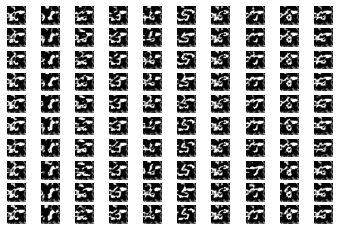

10001 [acc.: 100.00%, op_acc: 100.00%]
10002 [acc.: 100.00%, op_acc: 95.31%]
10003 [acc.: 100.00%, op_acc: 100.00%]
10004 [acc.: 100.00%, op_acc: 98.44%]
10005 [acc.: 100.00%, op_acc: 100.00%]
10006 [acc.: 100.00%, op_acc: 96.88%]
10007 [acc.: 100.00%, op_acc: 98.44%]
10008 [acc.: 100.00%, op_acc: 96.88%]
10009 [acc.: 100.00%, op_acc: 100.00%]
10010 [acc.: 100.00%, op_acc: 98.44%]
10011 [acc.: 100.00%, op_acc: 98.44%]
10012 [acc.: 100.00%, op_acc: 98.44%]
10013 [acc.: 100.00%, op_acc: 98.44%]
10014 [acc.: 100.00%, op_acc: 100.00%]
10015 [acc.: 100.00%, op_acc: 98.44%]
10016 [acc.: 100.00%, op_acc: 98.44%]
10017 [acc.: 100.00%, op_acc: 92.19%]
10018 [acc.: 100.00%, op_acc: 96.88%]
10019 [acc.: 100.00%, op_acc: 100.00%]
10020 [acc.: 100.00%, op_acc: 95.31%]
10021 [acc.: 100.00%, op_acc: 100.00%]
10022 [acc.: 100.00%, op_acc: 96.88%]
10023 [acc.: 100.00%, op_acc: 95.31%]
10024 [acc.: 100.00%, op_acc: 96.88%]
10025 [acc.: 100.00%, op_acc: 98.44%]
10026 [acc.: 100.00%, op_acc: 98.44%]
10027

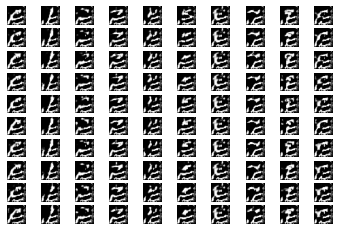

12001 [acc.: 100.00%, op_acc: 100.00%]
12002 [acc.: 100.00%, op_acc: 100.00%]
12003 [acc.: 100.00%, op_acc: 100.00%]
12004 [acc.: 100.00%, op_acc: 98.44%]
12005 [acc.: 100.00%, op_acc: 98.44%]
12006 [acc.: 100.00%, op_acc: 98.44%]
12007 [acc.: 100.00%, op_acc: 98.44%]
12008 [acc.: 100.00%, op_acc: 98.44%]
12009 [acc.: 100.00%, op_acc: 96.88%]
12010 [acc.: 100.00%, op_acc: 98.44%]
12011 [acc.: 100.00%, op_acc: 98.44%]
12012 [acc.: 100.00%, op_acc: 98.44%]
12013 [acc.: 100.00%, op_acc: 98.44%]
12014 [acc.: 100.00%, op_acc: 98.44%]
12015 [acc.: 100.00%, op_acc: 98.44%]
12016 [acc.: 100.00%, op_acc: 100.00%]
12017 [acc.: 100.00%, op_acc: 98.44%]
12018 [acc.: 100.00%, op_acc: 100.00%]
12019 [acc.: 100.00%, op_acc: 100.00%]
12020 [acc.: 100.00%, op_acc: 98.44%]
12021 [acc.: 100.00%, op_acc: 100.00%]
12022 [acc.: 100.00%, op_acc: 100.00%]
12023 [acc.: 100.00%, op_acc: 98.44%]
12024 [acc.: 100.00%, op_acc: 100.00%]
12025 [acc.: 100.00%, op_acc: 98.44%]
12026 [acc.: 100.00%, op_acc: 98.44%]
120

In [7]:
# Build and compile the discriminator
discriminator = build_discriminator()
discriminator.compile(loss=losses,
    optimizer=optimizer,
    metrics=['accuracy'])
  
# Build the generator
generator = build_generator()
  
# Defining the input for the generator 
#and generating the images 
noise = Input(shape=(latent_dim,))
label = Input(shape=(1,))
image = generator([noise, label])
  
# Disable the Discriminator 
# For the combined model we will only train the generator
discriminator.trainable = False
  
# The discriminator takes in the generated image
# as input and determines validity
# and the label of that image
valid, target_label = discriminator(image)
  
# The combined model (both generator and discriminator)
# Training the generator to fool the discriminator
combined = Model([noise, label], [valid, target_label])
combined.compile(loss=losses, optimizer=optimizer)
  
train_acgan(epochs=14000, batch_size=32, sample_interval=2000)